In [140]:
%config IPCompleter.greedy=True
from queue import *

In [141]:
#g = graphs.CycleGraph(4)
g = Graph(8, multiedges=True) #Graph({0: [1], 1: [2,3], 3: [4,5]})
g.add_edge(0,1)
g.add_edge(0,2)
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(1,3)
g.add_edge(3,6)
g.add_edge(3,4)
g.add_edge(3,5)
g.add_edge(3,7)
g.add_edge(4,5)
g.add_edge(5,7)
g.add_edge(4,6)
g.add_edge(5,6)
g.add_edge(7,6)

# pos = {0:[0.0, 1.5], 1:[-0.8, 0.3], 2:[-0.6, -0.8]

In [142]:
m = Matroid(g)
#m.basis
#iterator = m.bases()
#for i in iterator:
    #print(i)

In [143]:
class IndependentSet():
    def __init__(self, g):
        self.G = Graph(g.order())

    def I(self):
        return self.G.edges()

In [144]:
# https://medium.com/100-days-of-algorithms/day-41-union-find-d0027148376d
def find(data, i):
    if i != data[i]:
        data[i] = find(data, data[i])
    return data[i]

def union(data, i, j):
    pi, pj = find(data, i), find(data, j)
    if pi != pj:
        data[pi] = pj

In [145]:
def rootTree(self, root, treenumber, I):
    d = DiGraph()
    q = Queue()
    q.put(root)
    levelordernumber = 0
    
    while not q.empty():
        v = q.get()
        levelordernumber += 1
        I.Levelordernumbers[v] = levelordernumber
        I.Visited[v] = True
        I.Treenumbers[v] = treenumber
        
        for n in self.neighbor_iterator(v):
            if not I.Visited[n]:
                d.add_edge(v,n)
                q.put(n)
                
    return d
        
Graph.rootTree = rootTree

In [146]:
def c((a,b,_), I):
    if I.Treenumbers[a] != I.Treenumbers[b]:
        return None
    
    cycle = []
    tree = I.Trees[I.Treenumbers[a]]
    while a != b:
        n = a if I.Levelordernumbers[a] > I.Levelordernumbers[b] else b
        parent = tree.neighbors_in(n)[0]
        if find(I.Disjointsets, parent) != find(I.Disjointsets, n):
            cycle.append((parent, n, None))
            union(I.Disjointsets, parent, n)
        if I.Levelordernumbers[a] > I.Levelordernumbers[b]:
            a = parent
        else:
            b = parent
    
    return cycle

In [147]:
def start(Is):
    for I in Is:
        I.Treenumbers = [0] * g.order()
        I.Trees = list()
        I.Levelordernumbers = [0] * g.order()
        I.Visited = [False] * g.order()
        I.Disjointsets = [i for i in range(I.G.order())]
        components = I.G.connected_components_subgraphs()
        for idx, c in enumerate(components):
            rootedTree = c.rootTree(c.vertices()[0], idx, I)
            I.Trees.append(rootedTree)

In [148]:
def cyclic_scanning(e, k, labels, Is):
    q = Queue()
    q.put(e)
    while not q.empty():
        e = q.get()
        (_,i) = labels[e]
        i = (i + 1) % k
        cycle = c(e, Is[i])
        if cycle == None:
            return ((e,i), labels)
        for f in cycle:
            labels[f] = (e, i)
            q.put(f)
    return (None, labels)

In [149]:
def k_forest(g, k):
    Is = [IndependentSet(g) for i in range(k)]
    start(Is)
    label = None
    for e in g.edges():
        labels = {}
        labels[e] = (e,-1)
        if label != None:
            start(Is)
        (label, labels) = cyclic_scanning(e, k, labels, Is)
        if label != None:
            (f,i) = label
            while i != -1:
                Is[i].G.add_edge(f[:2] + (i,))
                if f != e:
                    i = (i - 1) % k
                    Is[i].G.delete_edge(f[:2] + (i,))
                (f,i) = labels[f]
    return Is

In [150]:
def top_clump(g, k):
    L = []
    Is = k_forest(g, k)
    B = Is[0].I() + Is[1].I()
    for e in B:
        ee = e
        start(Is)
        labels = {}
        labels[ee] = (ee,-1)
        (label, labels) = cyclic_scanning(ee, k, labels, Is)
        if label == None:
            L.append(e)
    return L

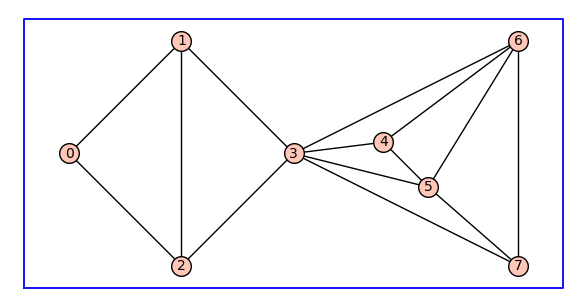

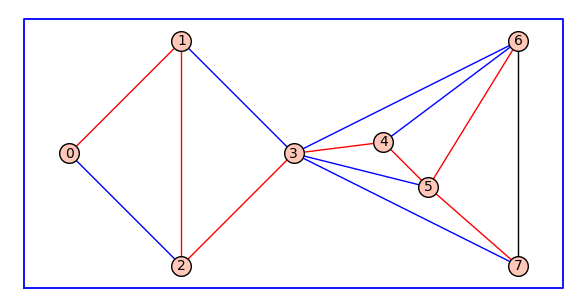

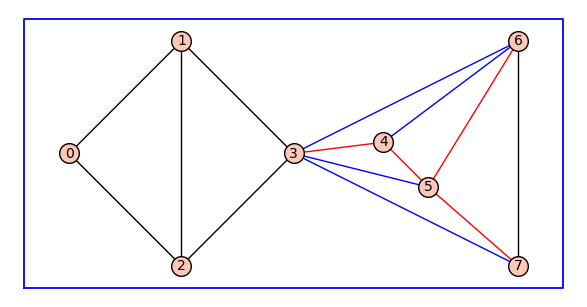

In [155]:
pos = {0:[0.0, 0.0], 1:[1.0, 1.0], 2:[1.0, -1.0], 3:[2.0, 0.0], 
       4:[2.8, 0.1], 5:[3.2, -0.3], 6:[4.0, 1.0], 7:[4.0, -1.0]}

p = g.plot(vertex_labels=True, graph_border=True, pos=pos)
p.show()



Is = k_forest(g, 2)
l1 = Is[0].I()
l2 = Is[1].I()
l = l1 + l2
res1 = set(map(lambda x: x[:2], g.edges()))
res2 = set(map(lambda x: x[:2], l))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
output = Graph({})
output.add_edges(r + l)
p = output.plot(vertex_labels=True, graph_border=True, color_by_label={0:(1,0,0), 1:(0,0,1)}, pos=pos)
p.show()



L = top_clump(g, 2)
res1 = set(map(lambda x: x[:2], g.edges()))
res2 = set(map(lambda x: x[:2], L))
res = res1.difference(res2)
r = map(lambda x: x + (-1,), list(res))
gg = Graph({})
gg.add_edges(r + L)
p = gg.plot(vertex_labels=True, graph_border=True, color_by_label={0:(1,0,0), 1:(0,0,1)}, pos=pos)
p.show()
